# Computational Social Science Project #2 

**Enter your Name: Brenda Sciepura

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1055]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv

## for training, test and validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [1056]:
# read in and inspect data frame
diabetes = pd.read_csv('/Users/brenda/github/Computational-Social-Science-Projects/Project 2/Diabetes with Population Info by County 2017.csv')

In [1057]:
# look at the dimensions of the data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [1058]:
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                                int64
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [1059]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows

# Filter rows where "Diabetes_Number" is non-numeric
non_numeric_rows = diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]

# Get unique values of the non-numeric "Diabetes_Number" column
unique_non_numeric_values = non_numeric_rows['Diabetes_Number'].unique()

In [1060]:
# Now do the same as above, but for "Obesity_Number"

# Filter rows where "Obesity_Number" is non-numeric
non_numeric_rows = diabetes[~diabetes['Obesity_Number'].str.isnumeric()]

# Get unique values of the non-numeric "Obesity_Number" column
unique_non_numeric_values = non_numeric_rows['Obesity_Number'].unique()

In [1061]:
# Now do the same as above, but for "Physical_Inactivity_Number" 

# Filter rows where "Physical_Inactivity_Number" is non-numeric
non_numeric_rows = diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]

# Get unique values of the non-numeric "Physical_Inactivity_Number" column
unique_non_numeric_values = non_numeric_rows['Physical_Inactivity_Number'].unique()

These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to (you'll have to scroll all the way over to the right).

In [1062]:
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 
diabetes = diabetes[diabetes['Diabetes_Number']!="No Data"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

In [1063]:
# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="Suppressed"] 
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

In [1064]:
# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="Suppressed"] 
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 

In [1065]:
# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

In [1066]:
# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [1067]:
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                         'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                         'sex and age_total population_sex ratio (males per 100 females)', 
                                                         'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                         'race_total population']]

In [1068]:
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [1069]:
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
CountyFIPS,3112.0,30374.235219,1001.000000,5.604500e+04
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [1070]:
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_one race_1']

In [1071]:
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) because there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [1072]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes['Region']

0       Southeast
1       Southeast
2       Southeast
3       Southeast
4       Southeast
          ...    
3215         West
3216         West
3217         West
3218         West
3219         West
Name: Region, Length: 3112, dtype: object

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

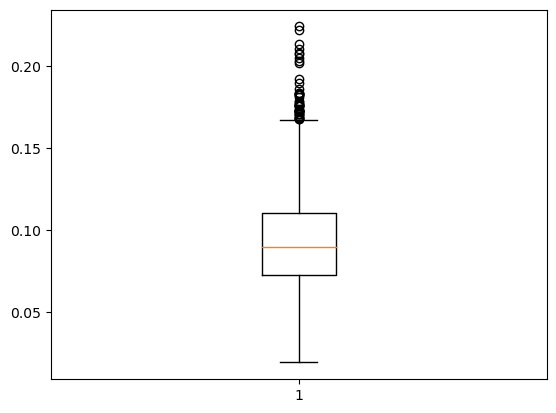

In [1073]:
# EDA # 1 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']

# Create the bar graph
plt.boxplot(y)

# Show the plot
plt.show()

## Interpretation
## This boxplot shows that the mean of the diabetes median is slightly below 10% but it's a skewed distribution due to the high number of outliers in the upper end of the distribution. This means that there are some counties in the country with a very high diabetes rate, that would probably be skewing the mean upwards. 

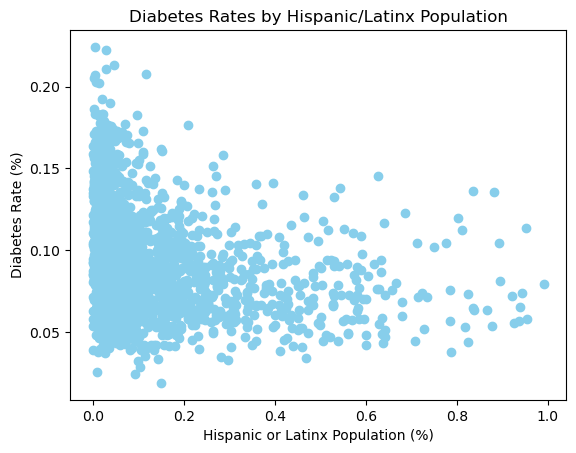

In [1074]:
# EDA # 2 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']
x = diabetes['hispanic or latino and race_total population_hispanic or latino (of any race)']

# Create the bar graph
plt.scatter(x, y, color='skyblue')
plt.ylabel('Diabetes Rate (%)')
plt.xlabel('Hispanic or Latinx Population (%)')
plt.title('Diabetes Rates by Hispanic/Latinx Population')

# Show the plot
plt.show()

## Interpretation: 
## This is a scatter plot of diabetes rates by Hispanic/Latinx Population which seems to indicate that counties with lower proportion of Hispanic/Latinx population are more likely to have higher diabetes rates. Conversely, counties with higher proportion of Latinx/Hispanic population have lower diabetes rates. 


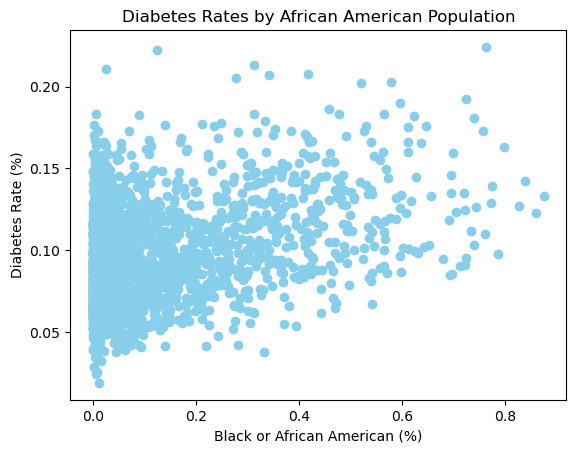

In [1075]:
# EDA # 3 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']
x = diabetes['race_total population_one race_black or african american']

# Create the bar graph
plt.scatter(x, y, color='skyblue')
plt.xlabel('Black or African American (%)')
plt.ylabel('Diabetes Rate (%)')
plt.title('Diabetes Rates by African American Population')

# Show the plot
plt.show()

## Interpretation
## This scatter plot indicates a positive correlation between diabetes and the percentage of African Americans in the population, as diabetes rates are higher in places with higher proportion of African Americans. 

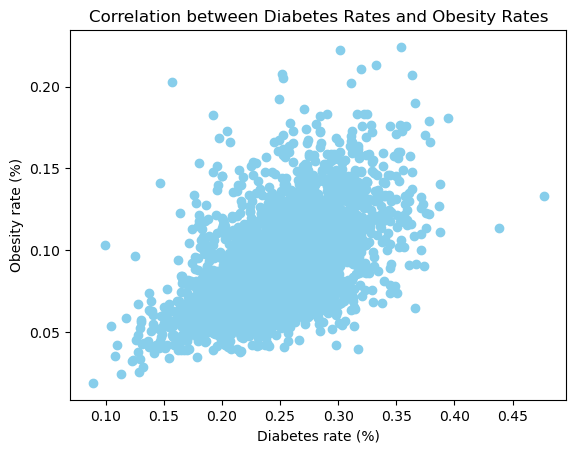

In [1076]:
# EDA # 4 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']
x = diabetes['Obesity_Number']

# Create the bar graph
plt.scatter(x, y, color='skyblue')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('Obesity rate (%)')
plt.title('Correlation between Diabetes Rates and Obesity Rates')

# Show the plot
plt.show()

## Interpretation
## We observe a strong positive correlation between diabetes rates and obesity rates, which means that overweight individuals are more likely to suffer from diabetes. 

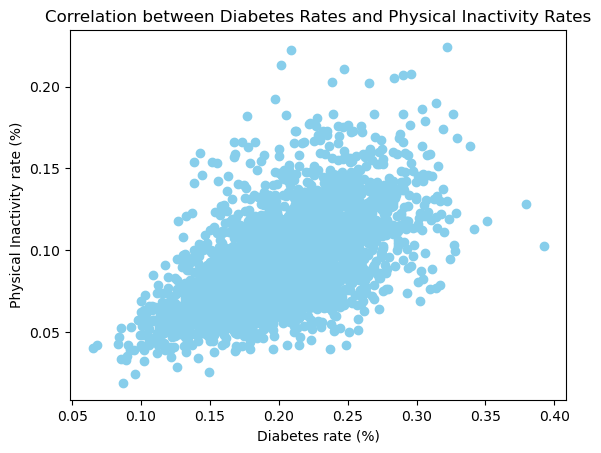

In [1077]:
# EDA # 5 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']
x = diabetes['Physical_Inactivity_Number']

# Create the bar graph
plt.scatter(x, y, color='skyblue')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('Physical Inactivity rate (%)')
plt.title('Correlation between Diabetes Rates and Physical Inactivity Rates')

# Show the plot
plt.show()

## Interpretation
## We observe a strong positive correlation between diabetes rates and physical inactivity rates, which means that being physically inactive is associated with experience of diabetes. However, this could also be due to the fact that physically inactive individuals are more likely to be overweight, so we're maybe already uncovering this relationship in the previous graph.  

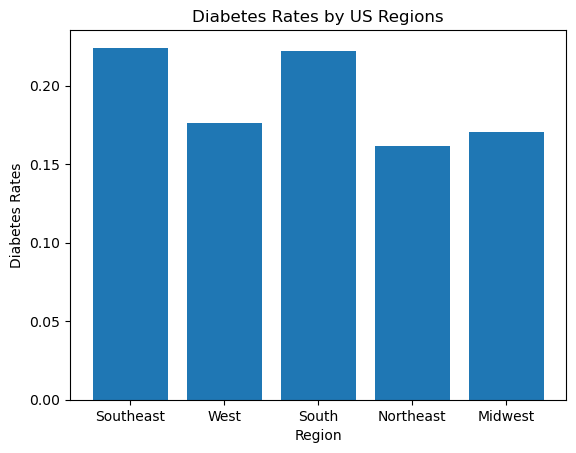

In [1078]:
# EDA # 5 and interpretations in this section 
#-----------

y = diabetes['Diabetes_Number']
x = diabetes['Region']

# Create the bar graph
plt.bar(x, y)
plt.xlabel('Region')
plt.ylabel('Diabetes Rates')
plt.title('Diabetes Rates by US Regions')

# Show the plot
plt.show()

## Interpretation: 
## We observe higher likelihood of diabetes in the south of the country, particularly the Southeast and Southern regions. 

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [1079]:
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes['Region'],  
                                drop_first = True) # drop the first as a reference 

In [1080]:
# drop 'County' and 'State' variables
diabetes = diabetes.drop(labels = ['County', 'State'],
                         axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

In [1081]:
## join diabetes and diabetes_clean
diabetes_new = pd.concat([diabetes, diabetes_clean], axis=1)

### 3.2 Feature Selection, Partition Data and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

# Feature selection

Investigate whether there are any features that you should remove prior to model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [1082]:
## columns to keep 
columns_to_keep = ['Diabetes_Number', 
                   'Obesity_Number', 
                   'Physical_Inactivity_Number', 
                   'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                   'race alone or in combination with one or more other races_total population_white', 
                   'race alone or in combination with one or more other races_total population_black or african american', 
                   'race alone or in combination with one or more other races_total population_american indian and alaska native',
                   'race alone or in combination with one or more other races_total population_asian', 
                   'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander',
                   'hispanic or latino and race_total population_hispanic or latino (of any race)', 
                   'total housing units', 
                   'sex and age_total population_male',
                   'sex and age_total population_62 years and over', 
                   'sex and age_total population_18 years and over_sex ratio (males per 100 females)',
                   'sex and age_total population_median age (years)']

diabetes_short = diabetes_new[columns_to_keep]

## Logic of decisions: 
## I removed most of specific race variables because of multicollinearity
## I removed "race_total_population" one race and two races and kept one variable per type of race except for one.
## I removed "citizen with specified age range" because I don't think the fact that someone is a citizen is predictive of the outcome (age, race and gender are more relevant)
## I removed "sex an age total population female" because of multicollinearity with male. I kept male because males are more likely to suffer from diabetes, so it's more interesting as the reference case. 
## I removed very specific variables not only for multicollinearity purposes but also because due to their specificity their values for single observations were close to zero (i.e. total population for certain tribal groups or each single measure for a specific Hispanic nationality)

# Partition data

In [1083]:
# create y dataframe 
y = diabetes_short['Diabetes_Number']

In [1084]:
# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_short.drop(columns=['Diabetes_Number'])

In [1085]:
# Training/test split
#-----------

# set the random seed
np.random.seed(10)

In [1086]:
# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                   # specify training dataset
                                                    y,                   # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [1087]:
# print shape of each newly created dataframe
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)

Shape of X train is (2489, 14)
Shape of y_train is (2489,)
Shape of X_test is (623, 14)
Shape of y_test is (623,)


In [1088]:
# verify proportional splits
print("60% of full dataset", X.shape[0]*.8)
print("20% of full dataset", X.shape[0]*.2)

60% of full dataset 2489.6000000000004
20% of full dataset 622.4000000000001


In [1089]:
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split?
X_train, X_validate, y_train, y_validate = train_test_split(X_train,         # specify training x
                                                            y_train,         # specify training y
                                                            train_size=0.75, # set training proportional spilt
                                                            test_size=0.25)  # set testing proportional split

In [1090]:
# print shape of each newly created dataframe
print("Shape of X train is", X_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of X_test is", X_test.shape)

Shape of X train is (1866, 14)
Shape of X_validate is (623, 14)
Shape of X_test is (623, 14)


In [1091]:
# verify proportional splits
print("60% of full dataset", X.shape[0]*.6)
print("20% of full dataset", X.shape[0]*.2)

60% of full dataset 1867.1999999999998
20% of full dataset 622.4000000000001


**On when to standardize: 

The best time to standardize the data is AFTER the training/validation/test split to avoid any information from the test data making its way into the training data (i.e. to avoid a leakage). Let's remember that the ultimate goal is to try the trained model within a new set of data (i.e. in this case making a diabetes prediction for so far unobserved county). If we standardize before the split, then information about the supposedly unknown sample will be contained in the standardized training data.

In [1092]:
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

In [1093]:
X_train.shape

(1866, 14)

In [1094]:
scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten().shape

(1866,)

In [1095]:
# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()
    
    # use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()


## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):

** OLS: Given that this prediction is for a continuous outcome, we'll try the traditional OLS regression. 

Pros: 
** coefficients easily interpretable
** if assumptions are met, it's efficient

Cons: 
** by using OLS we're making the assumption that the relationship between the IV and DV is linear, which may not be the case, and if it's not the case we will give inaccurate results
** OLS is sensitive to outliers in the data
** it might not perform so well in this case, as regression is optimized for inference and not prediction (lower traning error, higher test error).
** no feature selectionCons: 
** by using OLS we're making the assumption that the relationship between the IV and DV is linear, which may not be the case, and if it's not the case we will give inaccurate results
** OLS is sensitive to outliers in the data
** it might not perform so well in this case, as regression is optimized for inference and not prediction (lower traning error, higher test error).
** no feature selection

** LASSO

Pros:
** feature selection, which can simplify the model and reduce overfitting
** by making the model simpler, it also makes it easier to interpret
** useful when dealing with high-dimensional data, as is this dataset 
** Lasso's alpha can be fine-tuned using cross-validation, making it easy to find the optimal alpha for a specific dataset

Cons: 
** requires standardization (which happens here, so it's not a problem)
** might not always choose the most relevant features from a theoretic perspective, and if features are too correlated it might zero one out arbitrarily 
** not robust to outliers, and we have outliers in the data

** KNN

Pros: 
** does not assume linearity, does not make assumptions about the underlying data
** easy to understand
** it makes predictions based on local data, using the k-nearest neighbors which can be useful when the relationship between variables varies in different parts of the feature space. I guess we could say this applied to this dataset where observations are more likely to be similar in terms of multiple features within the same regions, for instance. 
** robust to outliers, especially when a small value of k is chosen 

Cons: 
** It's primarily a classification algorithm



### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1 Training: OLS 

In [1096]:
# create model
lin_reg = LinearRegression()

In [1097]:
lin_model = lin_reg.fit(X_train, y_train)

In [1098]:
## Tuning hyperparameters

# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}            # use dictionary for tuning

In [1099]:
# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,        # model to be tuned
                            param_grid = param_grid,     # parameters to be searched as specified above
                            cv=3,                        # 3-fold cross-validation to be used during hypertuning
                            refit = True)

In [1100]:
# now fit the tuning on the training data
lin_grid_reg.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]})

In [1101]:
# select the best performing model and predict with that on validation dataset
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)     # find best estimator and predict on validate

#### Model 2 Training: LASSO

In [1102]:
# create model
lasso_reg = Lasso(max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000

## fit model 
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

In [1103]:
## Tuning hyperparameters

# specify the hyperparameters
param_grid = {'alpha': np.arange(.001, 1, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

In [1104]:
# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3,       # 3-fold cross-validation to be used during hypertuning
                              refit=True)

In [1105]:
# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(max_iter=15000),
             param_grid={'alpha': array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901]),
                         'fit_intercept': [True, False],
                         'selection': ['cyclic', 'random']})

#### Model 3 Training: KNN 

In [1106]:
# Create a KNN regression model with the desired number of neighbors (k)
k = 5
knn_regressor = KNeighborsRegressor(n_neighbors=k)

In [1107]:
# Fit model 
knn_model = knn_regressor.fit(X_train, y_train)

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

#### Model 1 Predict on Validation Set OLS

In [1108]:
# using the validation dataset and the trained model, predict y
lin_pred = lin_grid_reg.predict(X_validate)

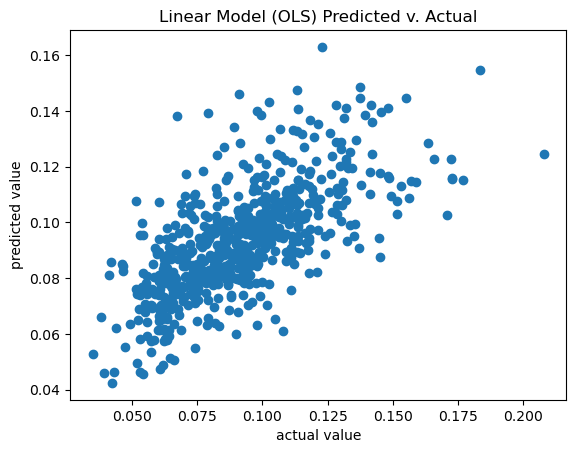

In [1109]:
# Plot the residuals on a scatter plot 

plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

## Interpretation: 
## For our model to be completely accurate this should have a slope of 1, and we see a straight line, which means the model is not very accurate. 

In [1110]:
# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': True}
Best CV R^2: 0.48381645103602083
Validation R^2: 0.4349290644589976


TypeError: 'numpy.float64' object is not callable

#### Model 2 Predict on Validation Set LASSO

In [ ]:
# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# Plot the residuals on a scatter plot 
plt.scatter(y_validate, best_lasso_pred)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [ ]:
# print the results  
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

In [ ]:
# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

#### Model 2 Predict on Validation Set KNN

In [ ]:
# Make predictions on the validation data
knn_pred = knn_regressor.predict(X_validate)

In [ ]:
# plot the predictions
plt.scatter(y_validate, knn_pred)
plt.title('KNN Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [ ]:
# RMSE
rmse_knn = rmse(knn_pred,  # specify predicted values 
                y_test)         # specify actual values  

# print the results  
print('Validation R^2:', knn_model.score(X_validate, y_validate))
print('Validation RMSE', rmse_knn)

#### Predict on test set using your best model

LASSO and OLS are pretty much the same in terms of performance. We pick OLS.  

In [ ]:
# Make predictions on the test set
lin_pred_test = lin_grid_reg.predict(X_test)

In [ ]:
# Estimate RMSE
rmse_lin_test = rmse(lin_pred_test,  # specify predicted values 
                     y_test)                # specify actual values  

print(f"Mean Squared Error: {rmse_lin_test}")

In [ ]:
# plot the predictions
plt.scatter(y_validate, lin_pred_test)
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

## Interpretation: The scatterplot is more disperse on the test set. 

In [ ]:
## Plot comparing coefficients for OLS and LASSO

# set the figure 
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 

figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 

# specify barplot for OLS 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lin_reg_data).set_title("OLS Coefficients")

# ensure the x-axis is the same on both plots
plt.xlim(-0.015, 0.015)

In [ ]:
# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")

## To answer question 3 on which regions we should include first in a pilot to tackle diabetes

In [ ]:
## join initial df with prediction data from the test set 
test_set_merged_with_initial_data = diabetes_new[diabetes_new.index.isin(X_test.index)]
test_set_merged_with_initial_data['Prediction'] = lasso_pred_test

In [ ]:
## grouping region and getting the mean of diabetes prediction in each to see if there are differences between regions.

In [ ]:
test_set_merged_with_initial_data.groupby(by=['Region']).agg({'Prediction':'mean'})
## we see no differences between regions

In [ ]:
## then we check whether we see differences within counties. here we get the 10 counties with higher diabetes prediction

In [ ]:
test_set_merged_with_initial_data.sort_values('Prediction', ascending = False).head(10)

## What is the advantage of using both validation and test sets in the social sciences and public policy?

Having separate test and validation sets allows researchers to compare multiple models. You can train and validate different models on the validation set and select the best-performing model for further testing on the test set. This helps ensure that the model generalizes well to unseen data.

The validation set can help identify overfitting. If a model performs really well on the training data but poorly on the validation set, it might be overfitting the training data, and you can take steps to fix this before you use your test set. In the same way, having a validation set allows for experimentation or parameter tuning to get the best possible model before using your test set. 


### 5.3 Implement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [ ]:
# specify cross validation
y_pred = cross_val_predict(estimator = lasso_grid_reg,        # specifcy object that is implementing fit 
                             X = X_train,                     # features
                             y = y_train,                     # target variable 
                             cv = 3)    # how many folds


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Evaluate the predictions
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('Cross-validation RMSE', rmse)

r2_score = r2_score(y_train, y_pred)
print('Cross-validation R2 Score', r2_score)

In [ ]:
## ANSWER: When we implement cross-validation with our LASSO model RSME does not change but we do get a higher R^2 (0.43 vs 0.48)

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to ML problems like this one?

Bias comes from the inability of a simplified model to approximate a complex real-world problem. Because the model makes some assumptions about the data that are not entirely accurate, it underfits the training data. Variance comes from random noise in the data which accounts for how much the model predictions would vary if they’re trained with different subsets of the data. Underfitting occurs when a model is not complex enough to accurately capture underlying data relationships. It performs poorly on the training and test data. The overall relationships between these 4 terms can be summarized as follows: a model with small variance and high bias will underfit (because it’s not capturing the underlying relationship of the data well), whereas a model with high variance and small bias will overfit (the model has a lot of data to truly capture the underlying data relationship but does not generalize well). In ML you worry more about the latter because of its inherent characteristics: large number of features and complex models. 

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting is an analysis that corresponds too closely or exactly to a particular set of data, which means the data is fitted too well and so it performs poorly on new data because it fails to make generalization of the underlying data patterns. The chance of overfitting increases with a higher dimensional model because you have more features to better fit the model and understand underlying patterns in the data, you have more flexibility, but the model is less generalizable. Regularization is a technique to prevent overfitting. It adds a penalty term for model complexity. The goal in ML is to find the right level of regularization that minimizes the error on the training and test data so that the model can make good generalizations when applied to new data, and this is how it’s connected to the bias-variance tradeoff. Regularization aims at finding the best balance between this too to achieve good model generalization. 

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

We observe no differences regarding diabetes prediction by county. All of them seem to have a pretty similar diabetes mean around 9%. However, we get the 10 top counties by prediction value. 

Given that in the OLS model the most predictive variables of diabetes seem to be obesity, physical inactivity, being African American and old age, we look for regions where these characteristics are prevalent and we find the following. In terms of obesity and physical inactivity, West seems to be the prioritized region, whereas if we take into account African American population and old age (population over 62 years old), we prioritize Southeast region. 